In [13]:
'''
Date: 2022-09-12 10:27:57
LastEditTime: 2022-09-12 13:39:29
LastEditors: Li Xiang
Description: 
FilePath: /2d.ipynb
'''

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from tqdm import trange

import numpy as np
import math


data = []

for i in range(512):
  
  x = random.uniform(-1, 1)
  y = random.uniform(-1, 1)
  
  # value = [x,x*(-1)**i]
  value = [x,y]
  
  # labels = math.sin(value[0]*math.pi*2)+math.sin(value[1]*math.pi*2)
  labels = value[0]*value[0]+value[1]*value[1]
  data.append((value, labels))

x = []
y = []
for i in range(len(data)):
  x.append(data[i][0])
  y.append(data[i][1])

xTensor = torch.Tensor(np.array(x)).cuda()
yTensor = torch.Tensor(np.array(y)).cuda()


In [14]:

HIDDEN_DIM = 32
HIDDEN_LAYER_NUM = 64


class ResInitLinear(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResInitLinear, self).__init__()
        assert input_dim == output_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(self.input_dim, self.output_dim)
        self.linear.weight = nn.Parameter(
            self.linear.weight+torch.eye(self.input_dim))

    def forward(self, x):
        out = self.linear(x)
        # out = self.act(out+x)
        return out


class Resx1BlockLinear(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Resx1BlockLinear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(self.input_dim, self.output_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.linear(x)
        out = self.act(out+x)
        return out


class Resx1BlockLinearBN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Resx1BlockLinearBN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(self.input_dim, self.output_dim)
        self.norm = nn.BatchNorm1d(self.output_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.linear(x)
        out = self.norm(out)
        out = self.act(out+x)
        return out


class ResBlockLinear(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResBlockLinear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear_1 = nn.Linear(self.input_dim, self.output_dim)
        self.norm_1 = nn.BatchNorm1d(self.output_dim)
        self.act_1 = nn.ReLU()
        self.linear_2 = nn.Linear(self.input_dim, self.output_dim)
        self.norm_2 = nn.BatchNorm1d(self.output_dim)
        self.act_2 = nn.ReLU()

    def forward(self, x):
        out = self.linear_1(x)
        out = self.norm_1(out)
        out = self.act_1(out)
        out = self.linear_2(out)
        out = self.norm_2(out)
        out = self.act_2(out+x)
        return out


class Resx1MLP(torch.nn.Module):
    def __init__(self):
        super(Resx1MLP, self).__init__()
        self.input_dim = 2
        self.hidden_dim = HIDDEN_DIM
        self.output_dim = 1
        self.hidden_layer_num = HIDDEN_LAYER_NUM
        layers = [nn.Linear(self.input_dim, self.hidden_dim), nn.ReLU()]
        for i in range(self.hidden_layer_num):
          layers.append(Resx1BlockLinear(self.hidden_dim, self.hidden_dim))
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out


class Resx1MLPBN(torch.nn.Module):
    def __init__(self):
        super(Resx1MLPBN, self).__init__()
        self.input_dim = 2
        self.hidden_dim = HIDDEN_DIM
        self.output_dim = 1
        self.hidden_layer_num = HIDDEN_LAYER_NUM
        layers = [nn.Linear(self.input_dim, self.hidden_dim), nn.ReLU()]
        for i in range(self.hidden_layer_num):
          layers.append(Resx1BlockLinearBN(self.hidden_dim, self.hidden_dim))
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out


class ResMLP(torch.nn.Module):
    def __init__(self):
        super(ResMLP, self).__init__()
        self.input_dim = 2
        self.hidden_dim = HIDDEN_DIM
        self.output_dim = 1
        self.hidden_layer_num = HIDDEN_LAYER_NUM//2
        layers = [nn.Linear(self.input_dim, self.hidden_dim), nn.ReLU()]
        for i in range(self.hidden_layer_num):
          layers.append(ResBlockLinear(self.hidden_dim, self.hidden_dim))
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out


class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 2
        self.hidden_dim = HIDDEN_DIM
        self.output_dim = 1
        self.hidden_layer_num = HIDDEN_LAYER_NUM
        self.l1 = nn.Linear(2, 1)
        layers = [nn.Linear(self.input_dim, self.hidden_dim), nn.ReLU()]
        for i in range(self.hidden_layer_num):
          layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
          layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out


class ResInitMLP(torch.nn.Module):
    def __init__(self):
        super(ResInitMLP, self).__init__()
        self.input_dim = 2
        self.hidden_dim = HIDDEN_DIM
        self.output_dim = 1
        self.hidden_layer_num = HIDDEN_LAYER_NUM
        self.l1 = nn.Linear(2, 1)
        layers = [nn.Linear(self.input_dim, self.hidden_dim), nn.ReLU()]
        for i in range(self.hidden_layer_num):
          layers.append(ResInitLinear(self.hidden_dim, self.hidden_dim))
          layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out


class MLPBN(torch.nn.Module):
    def __init__(self):
        super(MLPBN, self).__init__()
        self.input_dim = 2
        self.hidden_dim = HIDDEN_DIM
        self.output_dim = 1
        self.hidden_layer_num = HIDDEN_LAYER_NUM
        self.l1 = nn.Linear(2, 1)
        layers = [nn.Linear(self.input_dim, self.hidden_dim), nn.ReLU()]
        for i in range(self.hidden_layer_num):
          layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
          layers.append(nn.BatchNorm1d(self.hidden_dim))
          layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out


# model = MLP().cuda()
# model = Resx1MLP().cuda()
# model = Resx1MLPBN().cuda()
model = ResMLP().cuda()
# model = ResInitMLP().cuda()
# model = MLPBN().cuda()

criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-2)

batch_size = 64
data_len = yTensor.size()[0]
max_epoch = 1000
for epoch in range(max_epoch):
    batch_cnt = 0
    batch_val = []
    batch_lab = []
    for batch in range(data_len//batch_size):
        values = xTensor[batch*batch_size: (batch+1)*batch_size, ...]
        labels = yTensor[batch*batch_size: (batch+1)*batch_size, ...]
        output = model(values)

        optimizer.zero_grad()

        loss = criterion(output, labels.unsqueeze(1))
        loss.backward()

        optimizer.step()
    if epoch % 10 == 0:
        print("epoch: ", epoch, "loss: ", float(loss))
final_loss = float(loss)
print("final loss: ", final_loss)
print('training finished')


epoch:  0 loss:  0.9772815704345703
epoch:  10 loss:  0.0045935772359371185
epoch:  20 loss:  0.0090079540386796
epoch:  30 loss:  0.004671731032431126
epoch:  40 loss:  0.051697395741939545
epoch:  50 loss:  0.006475905887782574
epoch:  60 loss:  0.003559481119737029
epoch:  70 loss:  0.0008042354602366686
epoch:  80 loss:  0.001128763542510569
epoch:  90 loss:  0.030552592128515244
epoch:  100 loss:  0.03693196922540665
epoch:  110 loss:  0.0006714932969771326
epoch:  120 loss:  9.588782268110663e-05
epoch:  130 loss:  0.0004007758107036352
epoch:  140 loss:  0.0030120043084025383
epoch:  150 loss:  0.004223271273076534
epoch:  160 loss:  0.00423496775329113
epoch:  170 loss:  0.0016186609864234924
epoch:  180 loss:  0.0002524432784412056
epoch:  190 loss:  0.0023123854771256447
epoch:  200 loss:  0.03159588575363159
epoch:  210 loss:  0.00714455172419548
epoch:  220 loss:  9.298179065808654e-05
epoch:  230 loss:  4.076142067788169e-05
epoch:  240 loss:  0.0005659410962834954
epoch: 

100%|██████████| 1000/1000 [00:30<00:00, 33.03it/s]
/tmp/ipykernel_26751/1100864679.py:37: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


final loss, mean error:  0.0014308069366961718 0.035477135330438614


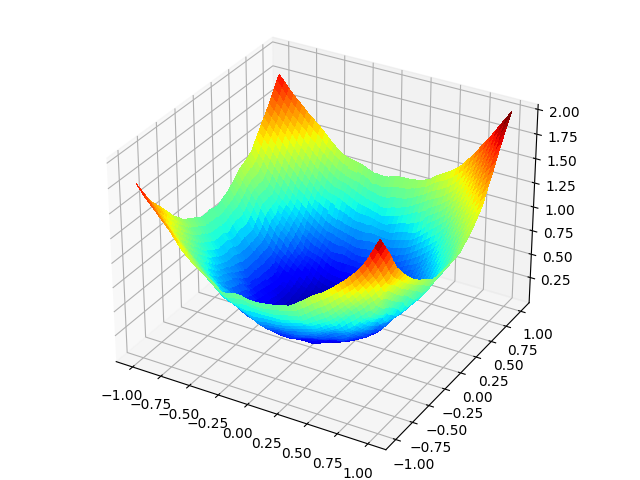

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import trange
X_STEP = 1000
Y_STEP = 1000
val_space = 1
xs = torch.linspace(-val_space, val_space, steps=X_STEP)
ys = torch.linspace(-val_space, val_space, steps=Y_STEP)
grid_x, grid_y = torch.meshgrid(xs, ys)

grid = torch.stack([grid_x, grid_y], dim=-1)
grid = grid.reshape(-1, 2).cpu()
model.eval()
eval_batch_size = X_STEP
out = []
for i in trange(grid.size()[0]//eval_batch_size):
    torch.cuda.empty_cache()
    res = model(grid[i * eval_batch_size:(i+1)*eval_batch_size, ...].cuda())
    res = res.detach().cpu()
    out.append(res)
    pass

out = torch.cat(out, dim=0)
# out = model(grid)

plot_points = torch.cat([grid, out], dim=1)

# for creating a responsive plot
%matplotlib widget

# importing required libraries

plot_points = plot_points.detach().cpu()
fig = plt.figure()
ax = Axes3D(fig)

# creating the plot
surf_points = plot_points.reshape(X_STEP, Y_STEP, 3)
surf_points_x = surf_points[..., 0]
surf_points_y = surf_points[..., 1]
surf_points_z = surf_points[..., 2]
surf_points_z_gt = surf_points_x*surf_points_x+surf_points_y*surf_points_y
surf_points_z_error = surf_points_z-surf_points_z_gt
print('final loss, mean error: ', float(final_loss), float(abs(surf_points_z_error).mean()))
surf = ax.plot_surface(surf_points_x, surf_points_y, surf_points_z, cmap=cm.jet,
                       linewidth=0, antialiased=False)
pass
